# Cal-CRAI Index: Weighting Climate Risk Scenarios

**Order of operations**:
- Metric handling
   - Retrieve & clean data
   - Merge data domains together
   - Calculate domain medians and adjusted scores
   - Mask SLR layers to non-coastal tracts
- Custom weight per scenairo
   - merge index scores per scenario together
- Bin values into _ sections

Note: Functions and figures within this notebook are in development

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import format_df, calculate_unweighted_index, calculate_weighted_index, weight_domains, print_index_summary, min_max_standardize
from scripts.utils.index_plots import index_plot, index_domain_plot

In [4]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data'
output_folder = 'aws_csvs'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data.


## Pull domain-specific index calculations from AWS

In [5]:
built_domain = pd.read_csv(r'aws_csvs/built_domain_index_calculation.csv')
governance_domain = pd.read_csv(r'aws_csvs/governance_domain_index_calculation.csv')
natural_domain = pd.read_csv(r'aws_csvs/natural_domain_index_calculation.csv')
society_domain = pd.read_csv(r'aws_csvs/society_economy_domain_index_calculation.csv')
climate_domain = pd.read_csv(r'aws_csvs/climate_domain_index_calculation.csv')

## Clean data, isolate relevant columns

In [6]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]

# For climate domain, keep first seven columns
climate_domain_cleaned = climate_domain.iloc[:, :7]

## Merge the core domain dataframes together

In [7]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

## Clean the merged core domain dataframe

In [8]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Rename the standardized columns for simplicity
merged_domains = merged_domains.rename(columns={
    'summed_indicators_governance_domain_min_max_standardized':'governance_domain_index',
    'summed_indicators_built_domain_min_max_standardized':'built_domain_index',
    'summed_indicators_natural_domain_min_max_standardized':'natural_systems_domain_index', 
    'summed_indicators_society_economy_domain_min_max_standardized':'society_economy_domain_index'     
})

# Display the dataframe
merged_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index
0,06001400100,0.651308,0.605062,0.518637,0.638723
1,06001400200,0.651308,0.553534,0.366578,0.646435
2,06001400300,0.651308,0.557473,0.338360,0.601674
3,06001400400,0.651308,0.549355,0.358216,0.580613
4,06001400500,0.651308,0.552923,0.367882,0.557130
...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506
9125,06115041001,0.682143,0.416459,0.466137,0.607022
9126,06115041002,0.682143,0.432561,0.584687,0.629400
9127,06115041101,0.682143,0.391202,0.683639,0.601162


## Calculate built, natural systems, and society & economy domain median values

In [9]:
all_domains = merged_domains.copy()
all_domains['built_median'] = merged_domains['built_domain_index'].median()
all_domains['natural_systems_median'] = merged_domains['natural_systems_domain_index'].median()
all_domains['society_economy_median'] = merged_domains['society_economy_domain_index'].median()

all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median
0,06001400100,0.651308,0.605062,0.518637,0.638723,0.642475,0.451652,0.58114
1,06001400200,0.651308,0.553534,0.366578,0.646435,0.642475,0.451652,0.58114
2,06001400300,0.651308,0.557473,0.338360,0.601674,0.642475,0.451652,0.58114
3,06001400400,0.651308,0.549355,0.358216,0.580613,0.642475,0.451652,0.58114
4,06001400500,0.651308,0.552923,0.367882,0.557130,0.642475,0.451652,0.58114
...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506,0.642475,0.451652,0.58114
9125,06115041001,0.682143,0.416459,0.466137,0.607022,0.642475,0.451652,0.58114
9126,06115041002,0.682143,0.432561,0.584687,0.629400,0.642475,0.451652,0.58114
9127,06115041101,0.682143,0.391202,0.683639,0.601162,0.642475,0.451652,0.58114


## Calculate built, natural systems, and society & economy domain adjusted values

In [10]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'{category}_domain_index'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in all_domains.iterrows():
    for category in ['natural_systems', 'society_economy', 'built']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        all_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted
0,06001400100,0.651308,0.605062,0.518637,0.638723,0.642475,0.451652,0.58114,0.148310,0.099085,-0.058232
1,06001400200,0.651308,0.553534,0.366578,0.646435,0.642475,0.451652,0.58114,-0.188363,0.112357,-0.138434
2,06001400300,0.651308,0.557473,0.338360,0.601674,0.642475,0.451652,0.58114,-0.250839,0.035334,-0.132304
3,06001400400,0.651308,0.549355,0.358216,0.580613,0.642475,0.451652,0.58114,-0.206877,-0.000908,-0.144939
4,06001400500,0.651308,0.552923,0.367882,0.557130,0.642475,0.451652,0.58114,-0.185476,-0.041315,-0.139386
...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506,0.642475,0.451652,0.58114,0.044468,0.109036,-0.270099
9125,06115041001,0.682143,0.416459,0.466137,0.607022,0.642475,0.451652,0.58114,0.032071,0.044536,-0.351789
9126,06115041002,0.682143,0.432561,0.584687,0.629400,0.642475,0.451652,0.58114,0.294550,0.083044,-0.326726
9127,06115041101,0.682143,0.391202,0.683639,0.601162,0.642475,0.451652,0.58114,0.513641,0.034453,-0.391102


## Bring in Climate Data

In [11]:
climate_domain_cleaned

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,6001400100,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510
1,6001400200,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643
2,6001400300,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542
3,6001400400,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913
4,6001400500,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532
...,...,...,...,...,...,...,...
9124,6115040902,0.409434,0.324800,0.382787,0.846492,0.000000,0.619160
9125,6115041001,0.382023,0.311958,0.374011,0.873744,0.000000,0.527876
9126,6115041002,0.396227,0.322660,0.377173,0.819991,0.000000,0.585439
9127,6115041101,0.361174,0.353338,0.322773,0.651207,0.000000,0.539505


## Pull SLR mask data

In [12]:
slr_mask_data = r'C:/Users/jespi/eagle/carb-climate-index-2/scripts/utils/slr_mask_layer.csv'
slr_mask = pd.read_csv(slr_mask_data)
slr_mask = slr_mask.drop(columns={'county', 'geometry', 'COUNTYFP'})

In [13]:
slr_mask

,GEOID,slr_impacted
0,6085504321,1
1,6085504410,1
2,6085507003,1
3,6085507004,1
4,6085502204,1
...,...,...
9124,6059001303,1
9125,6059001304,1
9126,6059001401,1
9127,6013367200,1


## Merge slr mask data with climate data

In [14]:
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].astype(str)
slr_mask['GEOID'] = slr_mask['GEOID'].astype(str)

processed_climate_df = pd.merge(climate_domain_cleaned, slr_mask, on='GEOID', how='left')
processed_climate_df

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized,slr_impacted
0,6001400100,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510,1
1,6001400200,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643,1
2,6001400300,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542,1
3,6001400400,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913,1
4,6001400500,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532,1
...,...,...,...,...,...,...,...,...
9124,6115040902,0.409434,0.324800,0.382787,0.846492,0.000000,0.619160,0
9125,6115041001,0.382023,0.311958,0.374011,0.873744,0.000000,0.527876,0
9126,6115041002,0.396227,0.322660,0.377173,0.819991,0.000000,0.585439,0
9127,6115041101,0.361174,0.353338,0.322773,0.651207,0.000000,0.539505,0


## If SLR impacted column is 0, set sea level rise column to NaN as they are inland tracts

In [15]:
processed_climate_df.loc[processed_climate_df['slr_impacted'] == 0, 'sea_level_rise_exposure_loss_product_min_max_standardized'] = np.nan

In [16]:
# turned off for now, but some tracts have a prefix that may be water tracts that could be masked?
'''# Identify GEOID values that start with '6099' in climate_domain_cleaned
submerged_coastal_rows = climate_domain_cleaned[climate_domain_cleaned['GEOID'].astype(str).str.startswith('6099')]['GEOID']

# Set the specific column to NaN for matching GEOIDs in processed_climate_df
processed_climate_df.loc[
    processed_climate_df['GEOID'].isin(submerged_coastal_rows), 
    'sea_level_rise_exposure_loss_product_min_max_standardized'
] = float('nan')'''

"# Identify GEOID values that start with '6099' in climate_domain_cleaned\nsubmerged_coastal_rows = climate_domain_cleaned[climate_domain_cleaned['GEOID'].astype(str).str.startswith('6099')]['GEOID']\n\n# Set the specific column to NaN for matching GEOIDs in processed_climate_df\nprocessed_climate_df.loc[\n    processed_climate_df['GEOID'].isin(submerged_coastal_rows), \n    'sea_level_rise_exposure_loss_product_min_max_standardized'\n] = float('nan')"

## Clean climate dataframe

In [17]:
# Ensure all values in GEOID are strings
processed_climate_df['GEOID'] = processed_climate_df['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
processed_climate_df['GEOID'] = processed_climate_df['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

processed_climate_df = processed_climate_df.drop(columns='slr_impacted')

# Display the dataframe
processed_climate_df

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,06001400100,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510
1,06001400200,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643
2,06001400300,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542
3,06001400400,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913
4,06001400500,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532
...,...,...,...,...,...,...,...
9124,06115040902,0.409434,0.324800,0.382787,0.846492,NaN,0.619160
9125,06115041001,0.382023,0.311958,0.374011,0.873744,NaN,0.527876
9126,06115041002,0.396227,0.322660,0.377173,0.819991,NaN,0.585439
9127,06115041101,0.361174,0.353338,0.322773,0.651207,NaN,0.539505


## Merge core and climate dataframes together

In [18]:
core_and_climate_domains = pd.merge(all_domains, processed_climate_df, on='GEOID', how='left')

In [19]:
core_and_climate_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,06001400100,0.651308,0.605062,0.518637,0.638723,0.642475,0.451652,0.58114,0.148310,0.099085,-0.058232,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510
1,06001400200,0.651308,0.553534,0.366578,0.646435,0.642475,0.451652,0.58114,-0.188363,0.112357,-0.138434,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643
2,06001400300,0.651308,0.557473,0.338360,0.601674,0.642475,0.451652,0.58114,-0.250839,0.035334,-0.132304,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542
3,06001400400,0.651308,0.549355,0.358216,0.580613,0.642475,0.451652,0.58114,-0.206877,-0.000908,-0.144939,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913
4,06001400500,0.651308,0.552923,0.367882,0.557130,0.642475,0.451652,0.58114,-0.185476,-0.041315,-0.139386,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506,0.642475,0.451652,0.58114,0.044468,0.109036,-0.270099,0.409434,0.324800,0.382787,0.846492,NaN,0.619160
9125,06115041001,0.682143,0.416459,0.466137,0.607022,0.642475,0.451652,0.58114,0.032071,0.044536,-0.351789,0.382023,0.311958,0.374011,0.873744,NaN,0.527876
9126,06115041002,0.682143,0.432561,0.584687,0.629400,0.642475,0.451652,0.58114,0.294550,0.083044,-0.326726,0.396227,0.322660,0.377173,0.819991,NaN,0.585439
9127,06115041101,0.682143,0.391202,0.683639,0.601162,0.642475,0.451652,0.58114,0.513641,0.034453,-0.391102,0.361174,0.353338,0.322773,0.651207,NaN,0.539505


## Custom Weighting to calculate Cal-CRAI score for specific climate risks
* utilize weight domains function to adjust domain coefficients to desired weighting factor

## Wildfire

In [57]:
# different weighting
df_fire = weight_domains(core_and_climate_domains, society=0.89, built=0.87, natural=0.72)
df_fire = calculate_weighted_index(df_fire, 'wildfire_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_fire = df_fire.rename(columns={'calcrai_score':'wildfire_scenario_calcrai_score'})

df_fire.to_csv('calcrai_index_wildfire_scenario_updated.csv', index=False)
print_index_summary(df_fire, 'wildfire_scenario_calcrai_score')

Min score / less resilience:  0.0
Max score / more resilience:  11.616427775130255
Mean score / average resilience:  1.9341388383771267
Median score / median resilience:  1.1209494284475157


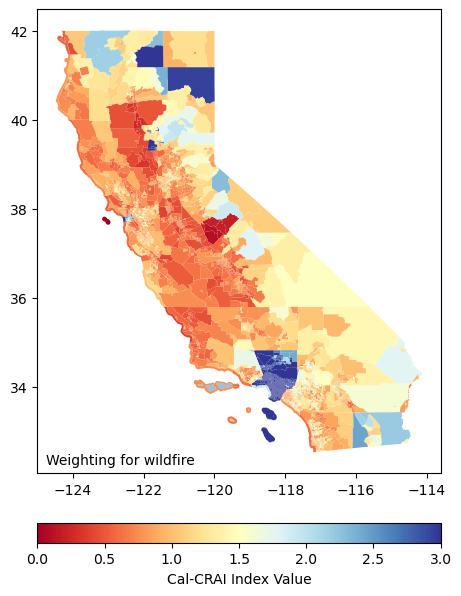

In [50]:
index_plot(df_fire, 'wildfire_scenario_calcrai_score', scenario='wildfire', vmin=0, vmax=3)

## Extreme Heat

In [52]:
df_heat = weight_domains(core_and_climate_domains, society=0.87, built=0.81, natural=0.75)
df_heat = calculate_weighted_index(df_heat, 'extreme_heat_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_heat = df_heat.rename(columns={'calcrai_score':'extreme_heat_scenario_calcrai_score'})

df_heat.to_csv('calcrai_index_heat_scenario_updated.csv', index=False)
print_index_summary(df_heat, 'extreme_heat_scenario_calcrai_score')


Min score / less resilience:  0.0
Max score / more resilience:  87.91925695197392
Mean score / average resilience:  1.6698527612142458
Median score / median resilience:  1.0729647492539782


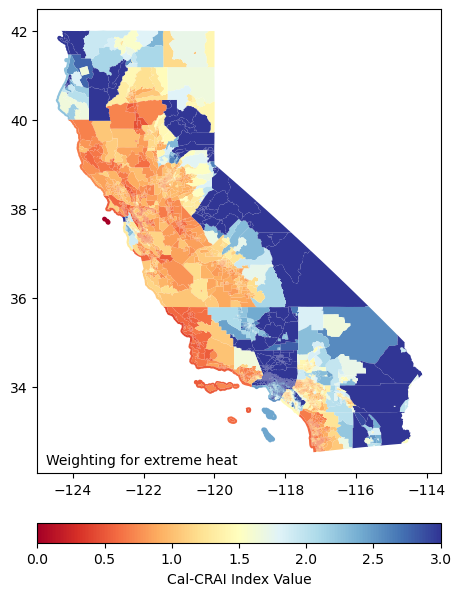

In [49]:
index_plot(df_heat, 'extreme_heat_scenario_calcrai_score', scenario='extreme heat', vmin=0, vmax=3)

## Inland Flooding

In [53]:
df_inland_flooding = weight_domains(core_and_climate_domains, society=0.92, built=0.83, natural=0.58)
df_inland_flooding = calculate_weighted_index(df_inland_flooding, 'inland_flooding_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_inland_flooding = df_inland_flooding.rename(columns={'calcrai_score':'inland_flooding_scenario_calcrai_score'})

df_inland_flooding.to_csv('calcrai_index_inland_flooding_scenario_updated.csv', index=False)
print_index_summary(df_inland_flooding, 'inland_flooding_scenario_calcrai_score')

Min score / less resilience:  0.0
Max score / more resilience:  9.042739778133742
Mean score / average resilience:  1.7121548919565037
Median score / median resilience:  1.3317068900064493


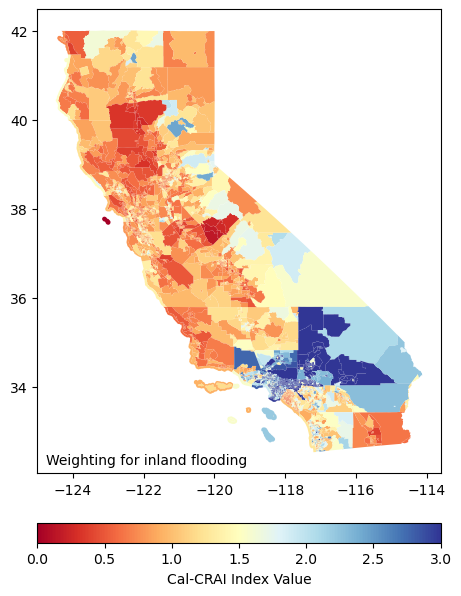

In [25]:
index_plot(df_inland_flooding, 'inland_flooding_scenario_calcrai_score', scenario='inland flooding', vmin=0, vmax=3)

## Sea Level Rise

In [61]:
df_sea_level_rise = weight_domains(core_and_climate_domains, society=0.92, built=0.75, natural=0.82)
df_sea_level_rise = calculate_weighted_index(df_sea_level_rise, 'sea_level_rise_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_sea_level_rise = df_sea_level_rise.rename(columns={'calcrai_score':'sea_level_rise_scenario_calcrai_score'})

df_sea_level_rise.to_csv('calcrai_index_sea_level_rise_scenario_updated.csv', index=False)
print_index_summary(df_sea_level_rise, 'sea_level_rise_scenario_calcrai_score')


Min score / less resilience:  0.0
Max score / more resilience:  15.904643767242417
Mean score / average resilience:  1.849009548011748
Median score / median resilience:  1.3951319187620153


In [27]:
df_sea_level_rise

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized,calcrai_weighted,sea_level_rise_scenario_calcrai_score
0,06001400100,0.651308,0.605062,0.518637,0.638723,0.642475,0.451652,0.58114,0.148310,0.099085,-0.058232,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510,0.761443,2.496683
1,06001400200,0.651308,0.553534,0.366578,0.646435,0.642475,0.451652,0.58114,-0.188363,0.112357,-0.138434,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643,0.550411,1.701635
2,06001400300,0.651308,0.557473,0.338360,0.601674,0.642475,0.451652,0.58114,-0.250839,0.035334,-0.132304,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542,0.473886,1.673984
3,06001400400,0.651308,0.549355,0.358216,0.580613,0.642475,0.451652,0.58114,-0.206877,-0.000908,-0.144939,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913,0.469477,1.535145
4,06001400500,0.651308,0.552923,0.367882,0.557130,0.642475,0.451652,0.58114,-0.185476,-0.041315,-0.139386,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532,0.459407,1.449549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506,0.642475,0.451652,0.58114,0.044468,0.109036,-0.270099,0.409434,0.324800,0.382787,0.846492,NaN,0.619160,0.637260,NaN
9125,06115041001,0.682143,0.416459,0.466137,0.607022,0.642475,0.451652,0.58114,0.032071,0.044536,-0.351789,0.382023,0.311958,0.374011,0.873744,NaN,0.527876,0.548054,NaN
9126,06115041002,0.682143,0.432561,0.584687,0.629400,0.642475,0.451652,0.58114,0.294550,0.083044,-0.326726,0.396227,0.322660,0.377173,0.819991,NaN,0.585439,0.731862,NaN
9127,06115041101,0.682143,0.391202,0.683639,0.601162,0.642475,0.451652,0.58114,0.513641,0.034453,-0.391102,0.361174,0.353338,0.322773,0.651207,NaN,0.539505,0.790983,NaN


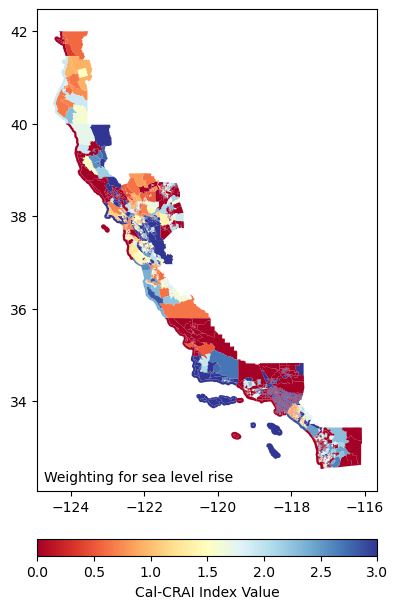

In [28]:
index_plot(df_sea_level_rise, 'sea_level_rise_scenario_calcrai_score', scenario='sea level rise',  vmin=0, vmax=3)

## Additional adjusting to SLR if desired
* set zero values to NaN as they are most of the coastline tracts that are likely underwater

In [29]:
df_sea_level_rise_no_zero = df_sea_level_rise.copy()
df_sea_level_rise_no_zero['sea_level_rise_scenario_calcrai_score'].replace(0, np.nan, inplace=True)
print_index_summary(df_sea_level_rise_no_zero, 'sea_level_rise_scenario_calcrai_score')

Min score / less resilience:  0.1646424000240791
Max score / more resilience:  15.904643767242417
Mean score / average resilience:  2.5445325022356107
Median score / median resilience:  1.9373536474351658


C:\Users\jespi\AppData\Local\Temp\ipykernel_30636\697686189.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sea_level_rise_no_zero['sea_level_rise_scenario_calcrai_score'].replace(0, np.nan, inplace=True)


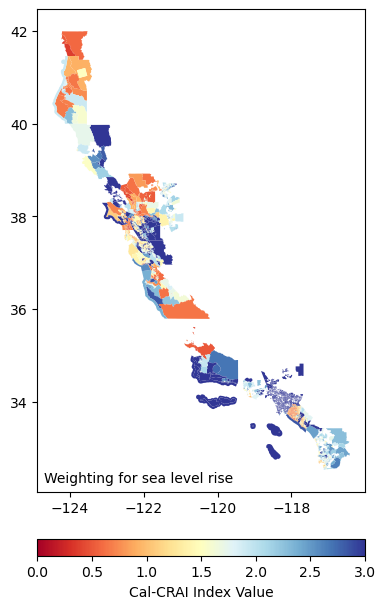

In [48]:
index_plot(df_sea_level_rise_no_zero, 'sea_level_rise_scenario_calcrai_score', scenario='sea level rise', vmin=0, vmax=3)

## Drought

In [55]:
df_drought = weight_domains(core_and_climate_domains, society=1.15, built=1.05, natural=1.42)
df_drought = calculate_weighted_index(df_drought, 'drought_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_drought = df_drought.rename(columns={'calcrai_score':'drought_scenario_calcrai_score'})

df_drought.to_csv('calcrai_index_drought_scenario_updated.csv', index=False)
print_index_summary(df_drought, 'drought_scenario_calcrai_score')

Min score / less resilience:  -0.35773907319228254
Max score / more resilience:  52.93991543634723
Mean score / average resilience:  2.8770730965241915
Median score / median resilience:  1.9866409479101863


In [41]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)

In [45]:
def index_plot(df, column, scenario=None, save=False, save_name=None, plot_type='continuous', vmin=-3, vmax=3):
    '''Maps the Cal-CRAI index value for the entire state'''

    # Merging with geographical boundaries
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2['geometry'] = df2['geometry']
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

    # Set up figure
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 6), layout='compressed')

    # Check plot type and set plotting parameters accordingly
    if plot_type == 'discrete':
        # For discrete values (1-5), use discrete colormap
        df2.plot(column=column, ax=ax, legend=True, cmap='RdYlBu', categorical=True)
        ax.get_legend().set_title("Cal-CRAI Binned Values \n (20% increments)")
    else:
        # For continuous values, use continuous colormap
        sm = df2.plot(column=column, ax=ax, vmin=vmin, vmax=vmax, cmap='RdYlBu', legend=False)

        # Create a colorbar manually and set the title
        cbar = fig.colorbar(sm.collections[0], ax=ax, orientation='horizontal')
        cbar.set_label("Cal-CRAI Index Value")

    # Annotation for scenario
    if scenario is None:
        plt.annotate('Equal-weighted domains', xy=(0.02, 0.02), xycoords='axes fraction')
    else:
        plt.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')

    # Save figure if required
    if save:
        if save_name is None:
            save_name = column  # Default save name to column if not provided
        fig.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')  # Save the figure

    plt.show()  # Show the plot


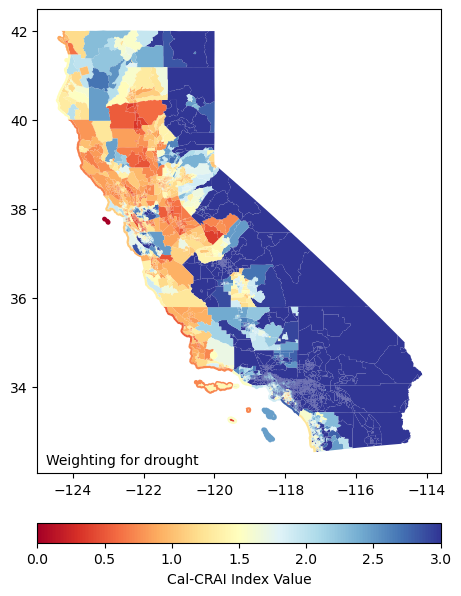

In [47]:
index_plot(df_drought, 'drought_scenario_calcrai_score', scenario='drought', vmin=0,vmax=3)

## Merge all weighted index scores together

In [37]:
# List of dataframes to merge
dfs = [df_drought, df_fire, df_heat, df_sea_level_rise, df_inland_flooding]

# Keep only 'geoid' and columns ending with '_calcrai_score' in each dataframe
dfs = [df[['GEOID'] + [col for col in df.columns if col.endswith('_calcrai_score')]] for df in dfs]

# Merge all dataframes on 'geoid' using an outer join
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on='GEOID', how='outer'), dfs)

# View the resulting merged dataframe
merged_df

,GEOID,drought_scenario_calcrai_score,wildfire_scenario_calcrai_score,extreme_heat_scenario_calcrai_score,sea_level_rise_scenario_calcrai_score,inland_flooding_scenario_calcrai_score
0,06001400100,0.936956,1.363921,0.974180,2.496683,1.190630
1,06001400200,0.531276,0.908110,0.693979,1.701635,1.397902
2,06001400300,0.416640,0.791683,0.578143,1.673984,0.823706
3,06001400400,0.422354,0.779206,0.571230,1.535145,1.214665
4,06001400500,0.414527,0.762288,0.559748,1.449549,0.782931
...,...,...,...,...,...,...
9124,06115040902,1.900532,0.720487,1.620650,NaN,0.993669
9125,06115041001,1.590521,0.590743,1.418688,NaN,0.991911
9126,06115041002,2.475002,0.833333,1.860136,NaN,1.137284
9127,06115041101,2.622357,1.110594,2.321367,NaN,1.270701


## Bin the weighted index scores into 5 quartiles

In [38]:
# Binning into quartiles
binned_df = merged_df.copy()

# Define the columns to bin
columns_to_bin = [
    'drought_scenario_calcrai_score',
    'wildfire_scenario_calcrai_score',
    'extreme_heat_scenario_calcrai_score',
    'sea_level_rise_scenario_calcrai_score',
    'inland_flooding_scenario_calcrai_score',
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_df[column], 
        q=5, 
        labels=False, 
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_df = binned_df.drop(columns=columns_to_bin)
binned_df

Bin edges for drought_scenario_calcrai_score: [-0.35773907  1.01141262  1.66503983  2.35581993  3.22241925 52.93991544]
Bin edges for wildfire_scenario_calcrai_score: [ 0.          0.81886468  1.02262782  1.26373598  4.0044407  11.61642778]
Bin edges for extreme_heat_scenario_calcrai_score: [ 0.          0.73041363  0.93776839  1.36287558  2.55840908 87.91925695]
Bin edges for sea_level_rise_scenario_calcrai_score: [ 0.          0.8595369   1.77888648  3.56394691 15.90464377]
Bin edges for inland_flooding_scenario_calcrai_score: [0.         0.82215075 1.13280732 1.62052879 2.78202741 9.04273978]


,GEOID,drought_scenario_calcrai_score_quartile,wildfire_scenario_calcrai_score_quartile,extreme_heat_scenario_calcrai_score_quartile,sea_level_rise_scenario_calcrai_score_quartile,inland_flooding_scenario_calcrai_score_quartile
0,06001400100,0,3,2,2.0,2
1,06001400200,0,1,0,1.0,2
2,06001400300,0,0,0,1.0,1
3,06001400400,0,0,0,1.0,2
4,06001400500,0,0,0,1.0,0
...,...,...,...,...,...,...
9124,06115040902,2,0,3,NaN,1
9125,06115041001,1,0,3,NaN,1
9126,06115041002,3,1,3,NaN,2
9127,06115041101,3,2,3,NaN,2


In [39]:
binned_df.to_csv('binned_weighted_data.csv', index=False)

## Visualize the weighted scenarios based on the binning results

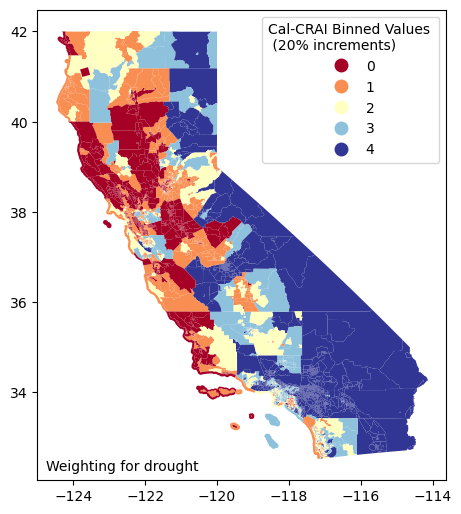

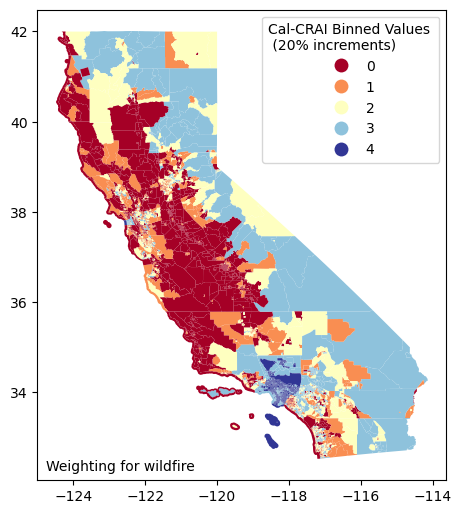

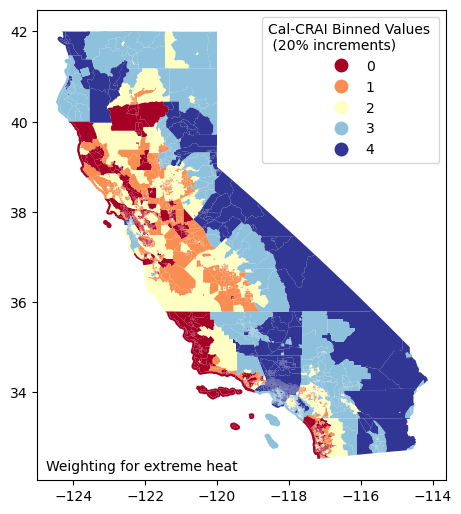

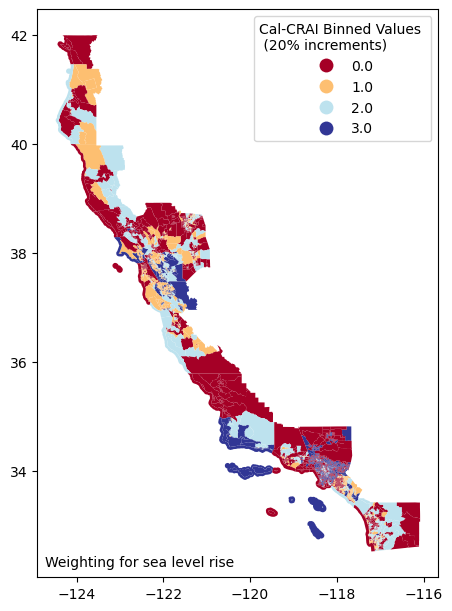

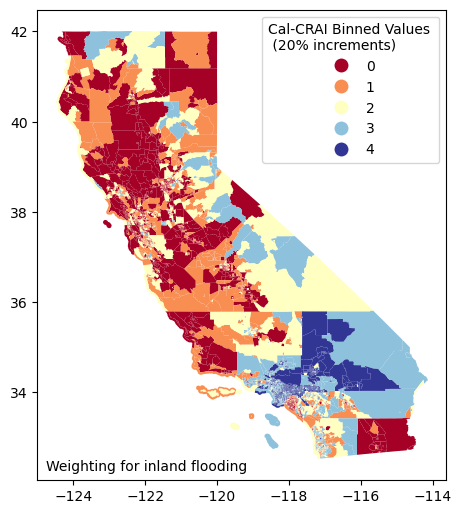

In [40]:
# List of binned columns
binned_columns = [
    'drought_scenario_calcrai_score_quartile',
    'wildfire_scenario_calcrai_score_quartile',
    'extreme_heat_scenario_calcrai_score_quartile',
    'sea_level_rise_scenario_calcrai_score_quartile',
    'inland_flooding_scenario_calcrai_score_quartile',
]

# Loop through each binned column and plot
for column in binned_columns:
    scenario_name = column.split('_scenario')[0]  # Get everything before '_scenario'
    scenario_name = scenario_name.replace('_', ' ')

    index_plot(binned_df, column, save=True, save_name=f'binned {scenario_name}', scenario=scenario_name, vmin=0, vmax=5, plot_type='discrete')

In [62]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files = ['calcrai_index_wildfire_scenario_updated.csv',
        'calcrai_index_heat_scenario_updated.csv',
        'calcrai_index_inland_flooding_scenario_updated.csv',
        'calcrai_index_sea_level_rise_scenario_updated.csv',
        'calcrai_index_drought_scenario_updated.csv']

for file in files:
    upload_csv_aws([file], bucket_name, directory)

calcrai_index_wildfire_scenario_updated.csv uploaded to AWS
calcrai_index_heat_scenario_updated.csv uploaded to AWS
calcrai_index_inland_flooding_scenario_updated.csv uploaded to AWS
calcrai_index_sea_level_rise_scenario_updated.csv uploaded to AWS
calcrai_index_drought_scenario_updated.csv uploaded to AWS
